# Processing Aguirre 2017
- Processing genomewide screen from [Aguirre et. al. 2017](https://cancerdiscovery.aacrjournals.org/content/6/8/914.long)
- Exons: For each gene, we excluded the first and last exons and any exon that
contained an alternative splicing site. Using these procedures, we chose 4 constitutive
exons for each gene.
- sgRNA design: Candidate sgRNAs with higher values of Sguide are predicted to have less off-target
activity.
For each gene, we chose 6 sgRNAs with the highest values of Sguide across all 4
constitutive exons (from step (1) ) subject to constraint that no more than 2 sgRNAs
could target a single exon.

### Data Filters
1. sgRNAs targetting essential genes
2. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool

In [2]:
lfc_df = (pd.read_csv('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/depmap-data/guide_QCed.csv')
          .rename({'Unnamed: 0': 'sgRNA Sequence'}, axis = 1))
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                names=['gene'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                    names=['gene'])

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


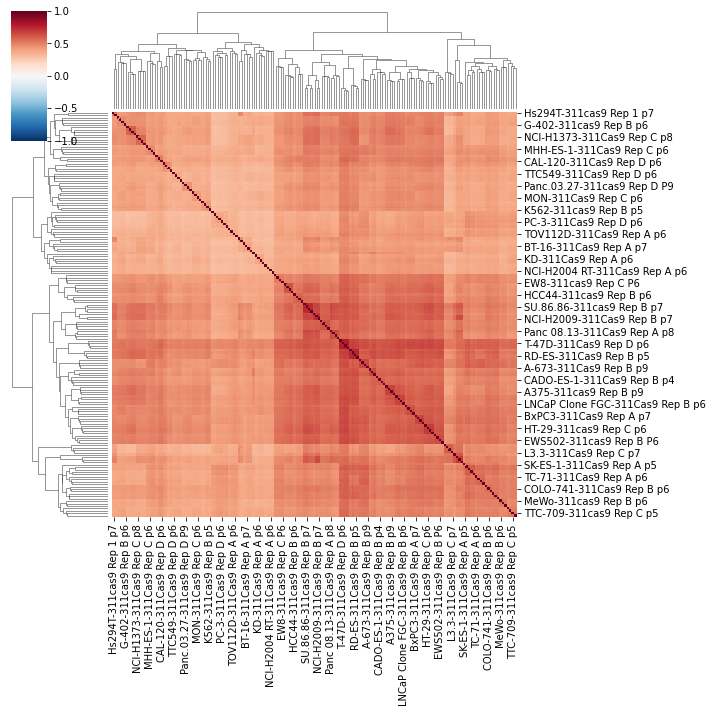

In [3]:
lfc_cors = lfc_df.corr()
sns.clustermap(lfc_cors, cmap='RdBu_r', vmin=-1, vmax=1)

In [4]:
long_cors = (lfc_cors.reset_index()
             .rename({'index': 'condition A rep'}, axis=1)
             .melt(var_name='condition B rep', value_name='pearson', id_vars='condition A rep'))
long_cors['condition A'] = long_cors['condition A rep'].str.split(' ', expand=True)[0]
long_cors['condition B'] = long_cors['condition B rep'].str.split(' ', expand=True)[0]
filtered_cors = long_cors[(long_cors['condition A rep'] != long_cors['condition B rep']) &
                          (long_cors['condition A'] == long_cors['condition B'])].copy()
filtered_cors['pearson'].mean()

0.5623745398970802

In [5]:
sg_list = list(lfc_df['sgRNA Sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [6]:
long_lfcs = pool.average_replicate_lfcs(lfc_df, 'sgRNA Sequence', [0], sep = ' ')

In [7]:
lfcs_designs = (long_lfcs
                .merge(design_df, how = 'inner', on = 'sgRNA Sequence'))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.gene,
                                fp_genes=nonessential_genes.gene, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs.sort_values('ROC-AUC')

,condition,ROC-AUC
18,L3.3-311Cas9,0.633589
28,PC-3-311Cas9,0.645573
34,SK-NEP-1-311Cas9,0.659272
35,SK-PN-DW-311Cas9,0.668938
41,TTC-709-311cas9,0.684969
17,KD-311Cas9,0.687459
38,TC-71-311Cas9,0.704634
3,BT-16-311Cas9,0.706843
32,RD-ES-311Cas9,0.709777
33,SK-ES-1-311Cas9,0.715928


In [8]:
roc_aucs['ROC-AUC'].mean()

0.745479154350558

In [9]:
roc_aucs.shape

(43, 2)

In [10]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.gene)]
ot_filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
print('Off target filtered: ' + str(int(relevant_sgs_designs.shape[0] - ot_filtered_sgs.shape[0])/43))
ot_filtered_sgs['neg_gene_zscore'] = (ot_filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.mean())/x.std()))
sg_avg_zscore = (ot_filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 'Target Cut %', 'On-Target Efficacy Score'])
                 .agg(avg_neg_gene_zscore = ('neg_gene_zscore', 'mean'))
                 .reset_index())
sg_avg_zscore_filtered = sg_avg_zscore[sg_avg_zscore.groupby('Target Gene Symbol')
                                       ['sgRNA Sequence']
                                       .transform(lambda x: x.count()) > 1].copy()
print('sgRNAs per gene filtered: ' + str(sg_avg_zscore.shape[0] - sg_avg_zscore_filtered.shape[0]))


Off target filtered: 423.0
sgRNAs per gene filtered: 10


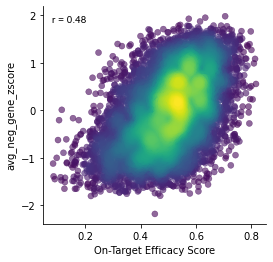

In [11]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sg_avg_zscore_filtered, y='avg_neg_gene_zscore', x='On-Target Efficacy Score')
gpplot.add_correlation(data=sg_avg_zscore_filtered, y='avg_neg_gene_zscore', x='On-Target Efficacy Score', 
                       method='spearman')
sns.despine()

In [12]:
training_data = sg_avg_zscore_filtered.drop(['On-Target Efficacy Score'], axis=1)
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,avg_neg_gene_zscore
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,CPSF6,22.2,-0.937178
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,SKA3,62.3,-0.714460
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AQR,3.8,1.092002
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,ZNHIT6,61.7,-0.267474
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,ABCF1,9.4,0.726254
...,...,...,...,...,...
8654,TTTGTGGCAGCGAATCATAA,TGTCTTTGTGGCAGCGAATCATAATGGTTC,UMPS,43.8,-0.726400
8655,TTTGTTAATATCTGCTGAAC,TGAATTTGTTAATATCTGCTGAACAGGAGT,GTF2A1,40.3,-0.526418
8656,TTTGTTAGGATGTGCATTCC,TTTCTTTGTTAGGATGTGCATTCCAGGTAC,NAT10,16.4,-1.034357
8657,TTTGTTAGGTCATCGTATTG,GGTTTTTGTTAGGTCATCGTATTGAGGAAG,RPL4,33.5,-1.269279


In [13]:
training_data.to_csv('../data/processed/Aguirre2017_activity.csv', index=False)